## 概述
自组织映射网络(Self-organizing Mapping)是一种常用的聚类方法。
> 注意：我们设置输出层的网络m*n,然后训练它，测试的时候，数据会被map到任意一个点上，我们认为相似的数据会聚集在相临的节点上。

## 网络结构
![som_structure.png](./sources/som_structure.png)
它常分为输入层与竞争层(输出层)。
- 输入层：假设一个输入样本为X=[x1,x2,x3,…,xn]，是一个n维向量，则输入层神经元个数为n个。
- 竞争层：通常输出层的神经元以矩阵方式排列在二维空间中，每个神经元都有一个权值向量，**权值向量维度与输入层样本维度相同**。假设输出层有m个神经元，则有m个权值向量。

> 注意上图中的$x_i$为第i个样本
> 输入层的每一个节点都与竞争层的所有节点全连接

## 算法步骤
1. **初始化**：初始化竞争层m的数目与m个元素的权值向量
2. **输入比较**：样本输入网络，通过比较样本与m个权值向量的相似性，记相似性最大的竞争层节点为获胜者
3. **调整权值**：更新获胜者节点的权值
4. **循环迭代**：重复2，3

### 初始化
每个竞争层节点的权值可以初始化为（0, 1）之间的随机数。

In [21]:
import random
def initOutputLayer(m, n):  # m为竞争层节点数目；n为每一个节点的维度
    layers = []
    random.seed()
    for i in range(m):
        unit = []  # 每一个节点
        for j in range(n):
            unit.append(round(random.random(),2))
        layers.append(unit)
    return layers

m = 5
n = 2
layers = initOutputLayer(m, n)
print("Output layers:", layers)

Output layers: [[0.92, 0.99], [0.91, 0.23], [0.35, 0.67], [0.51, 0.12], [0.64, 0.1]]


### 输入比较
做比较之间可以先对所有的竞争层节点权值向量与输入向量归一化，然后再使用如**欧式距离**比较相似度。  
竞争层第j个节点的权值归一化计算方式：$W_j=\dfrac{W_j}{||W_j||}$  
输入向量归一化计算方式：$X=\dfrac{X}{||X||}$  
两个维度都为n的向量之间的欧式距离计算方式：
![som_udistance.png](./sources/som_udistance.png)
> 这里$X$与$W_j$都是n维向量  
> ||X||为二范数，其代表该向量的长度，是一个标量  
> 相似度比较函数可参考：https://www.cnblogs.com/liujinhong/p/6001997.html

#### 合作过程
当一个神经元被激活时，最近的邻居节点往往比那些远离的邻居节点更兴奋。并且存在一个随距离衰减的拓扑邻域。如果$S_{ij}$是竞争层两个神经元之间的距离，则拓扑领域为:  
$T_{j,I(x)}=exp(-\dfrac{S_{j,I(x)}^2}{2\sigma^2})$  
其中$I(x)$为获胜神经元索引。该函数有几个重要的特性：  
- 它在获胜的神经元中是最大的，且关于该神经元对称
- 当距离达到无穷大时，它单调地衰减到零。  

SOM的一个特点是$\sigma$需要随着时间的推移而减少，这实际上就是一个拓扑域逐渐减小的过程。常见的时间依赖性关系是指数型衰减：  
$\sigma(t)=\sigma_0exp(\dfrac{-t}{t_\sigma})$  
这样不仅获胜的神经元能够得到权重更新，它的邻居也将更新它们的权重，尽管不如获胜神经元更新的幅度大。

In [22]:
import numpy.linalg as LA  # 计算范数
import math

def normalization(v):  # v为向量
    norm = LA.norm(v, 2)  # 计算2范数
    v_new = []
    for i in range(len(v)):
        v_new.append(round(v[i]/norm,2))  # 保留2位小数
    return v_new

def normalizationVList(X):  
    X_new = []
    for x in X:
        X_new.append(normalization(x))
    return X_new

def calSimilarity(x, y):  # 计算x,y两个向量的相似度
    if len(x)!=len(y):
        raise "维度不一致！"
    c = 0
    for i in range(len(x)):
        c += pow((x[i] - y[i]), 2)
    return  math.sqrt(c)

def getWinner(x, layers):  # 找到layers里面与x最相似的节点
    # x = normalization(x)
    # layers = normalizationVList(layers)
    min_value = 100000  # 存储最短距离
    min_index = -1  # 存储跟x最相似节点的竞争层节点index
    for i in range(len(layers)):
        v = calSimilarity(x, layers[i])
        if v < min_value:
            min_value = v
            min_index = i
    return min_index  # 返回获胜节点index
    
# 输入数据处理
X = [[1, 2], [3, 4], [5, 6], [7, 8], [2, 3]]  # 输入列表
X_norm = normalizationVList(X)
print("Inputs normalization:", X_norm)  # 输入数据归一化
# 权值处理
layers_norm = normalizationVList(layers)
print("Weights normalization:", layers_norm)  # 权值归一化
# 计算某一个x输入的竞争层胜利节点
winner_index = getWinner(X_norm[0], layers_norm)
print("Winner index:", winner_index)

Inputs normalization: [[0.45, 0.89], [0.6, 0.8], [0.64, 0.77], [0.66, 0.75], [0.55, 0.83]]
Weights normalization: [[0.68, 0.73], [0.97, 0.25], [0.46, 0.89], [0.97, 0.23], [0.99, 0.15]]
Winner index: 2


### 调整权值
#### 只有竞争单元调整
竞争胜利的单元可以调整自己的权值，调整方式可以采用如下方式：  
$w(t+1) = w(t) + \alpha(x-w(t))$

> 其中$\alpha$为学习率，它可以通过如下式子计算：  
> $\alpha=f(t)e^{-n}$ (其中`f(t)`为迭代次数的倒数)

#### 拓扑域内调整
假设输入单元i和神经元j的连接权重为$w_{ji}$,则第j个神经元到第i个输入单元的权值差值可由以下式子计算：  
$\Delta w_{ji} = \alpha(t)T_{j,I(x)}(t)(x_i - w_{ji})$  
$\alpha(t)$是依赖时间的学习率：$\alpha(t)=\alpha_0exp(\dfrac{-t}{t_\alpha})$  

In [23]:
# 只有竞争单元调整
def adjustWeight(w, x, alpha):  # w为要调整的权值向量；x为输入向量；alpha为学习率
    if len(w)!=len(x):
        raise "w,x维度应该相等！"
    w_new = []
    for i in range(len(w)):
        w_new.append(w[i] + alpha*(x[i] - w[i]))
    return w_new

alpha = 0.5  # 学习参数
print("After Adjust:", adjustWeight(layers[winner_index], X[0], alpha))

After Adjust: [0.675, 1.335]


###  循环迭代
重复输入比较与调整权值，可以选择在以下条件成立时结束迭代：  
- 学习率小于某个阈值
- 达到预设的迭代次数

## 整体代码
完整代码如下所示。

No handles with labels found to put in legend.


Original layers: [[0.74, 0.0], [0.33, 0.73], [0.51, 0.66]]
After train layers: [[0.9090820650777696, 0.2805652370465652], [0.12340181297278771, 0.38986865322492825], [0.79354190099109, 0.6946147365909863]]


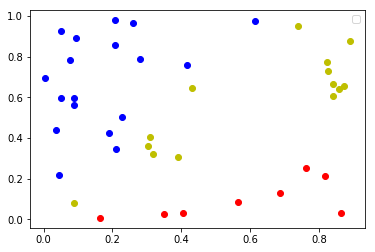

In [24]:
import random
import matplotlib.pyplot as plt

def createData(num, dim):  # 数据组数与数据维度
    data = []
    for i in range(num):
        pair = []
        for j in range(dim):
            pair.append(random.random())
        data.append(pair)
    return data

# 参数设置
train_times = 10  # 训练次数
data_dim = 2 # 数据维度
train_num = 160
test_num = 40
learn_rate = 0.5  # 学习参数

# 生成数据
random.seed()
# 生成训练数据
train_X = createData(train_num, data_dim)
# 生成测试数据
test_X = createData(test_num, data_dim)
# print(test_X)

# 初始化m个类
m = 3  # m个类别
layers = initOutputLayer(m, data_dim)
print("Original layers:", layers)

# 开始迭代训练
while train_times > 0:
    for i in range(train_num):
        # 权值归一化
        layers_norm = normalizationVList(layers)
        # 计算某一个x输入的竞争层胜利节点
        winner_index = getWinner(train_X[i], layers_norm)
        # 修正权值
        layers[winner_index] = adjustWeight(layers[winner_index], train_X[i], learn_rate)
    train_times -= 1
print("After train layers:", layers)

# 测试
for i in range(test_num):
    # 权值归一化
    layers_norm = normalizationVList(layers)
    # 计算某一个x输入的竞争层胜利节点
    winner_index = getWinner(test_X[i], layers_norm)
    # 画图
    color = "ro"
    if winner_index == 0:
        color = "ro"
    elif winner_index == 1:
        color = "bo"
    elif winner_index == 2:
        color = "yo"
    plt.plot(test_X[i][0], test_X[i][1], color)
plt.legend()
plt.show()

参考文献：  
1. https://www.cnblogs.com/surfzjy/p/7944454.html